# **Data Cleaning**

In [ ]:
import csv

# Load CSV data into a list of dictionaries
file_path = 'Customers.csv'

with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    data = [row for row in reader]

# Function to handle missing values
def handle_missing_values(data, numerical_columns):
    for row in data:
        for col in row:
            if row[col] == "" or row[col] is None:
                if col in numerical_columns:
                    # Replace with column mean (calculated separately)
                    row[col] = numerical_means[col]
                else:
                    # Replace with column mode (calculated separately)
                    row[col] = column_modes[col]

# Calculate means for numerical columns
numerical_columns = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
numerical_means = {}

for col in numerical_columns:
    values = [float(row[col]) for row in data if row[col] not in ["", None]]
    numerical_means[col] = sum(values) / len(values)

# Calculate modes for categorical columns
categorical_columns = ['Gender', 'Profession']
column_modes = {}

for col in categorical_columns:
    values = [row[col] for row in data if row[col] not in ["", None]]
    column_modes[col] = max(set(values), key=values.count)

# Remove outliers using the IQR method
def remove_outliers(data, column):
    values = [float(row[column]) for row in data if row[column] not in ["", None]]
    Q1 = sorted(values)[len(values) // 4]
    Q3 = sorted(values)[3 * len(values) // 4]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return [row for row in data if row[column] not in ["", None] and lower_bound <= float(row[column]) <= upper_bound]

# Apply outlier removal
for col in numerical_columns:
    data = remove_outliers(data, col)

# Filter rows based on a condition (e.g., Age > 18)
data = [row for row in data if float(row['Age']) > 18]

# Save the cleaned data to a new CSV file
cleaned_file_path = 'Cleaned_Customers_Raw.csv'
with open(cleaned_file_path, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=data[0].keys())
    writer.writeheader()
    writer.writerows(data)

print("Data cleaning completed and saved to", cleaned_file_path)

Data cleaning completed and saved to Cleaned_Customers_Raw.csv


# 3NF

In [ ]:
import sqlite3
import csv

# File path for the cleaned data
cleaned_file_path = 'Cleaned_Customers_Raw.csv'

# Load cleaned data into a list
with open(cleaned_file_path, 'r') as file:
    reader = csv.DictReader(file)
    cleaned_data = [row for row in reader]
# Normalize the data
# Extract unique professions with work experience
professions = list(set((row['Profession'], str(row['Work Experience'])) for row in cleaned_data))

# Create mappings for professions
profession_map = {profession: idx + 1 for idx, profession in enumerate(professions)}

# Create normalized tables
customers = [
    {
        'CustomerID': row['CustomerID'],
        'Gender': row['Gender'],
        'Age': row['Age'],
        'Family_Size': row['Family Size'],
        'ProfessionID': profession_map[(row['Profession'], str(row['Work Experience']))],
    }
    for row in cleaned_data
]

profession_table = [
    {'ProfessionID': idx, 'Profession': profession, 'Work_Experience': work_exp}
    for (profession, work_exp), idx in profession_map.items()
]

finances = [
    {
        'CustomerID': row['CustomerID'],
        'Annual_Income': row['Annual Income ($)'],
        'Spending_Score': row['Spending Score (1-100)'],
    }
    for row in cleaned_data
]

# Connect to SQLite
db_path = 'Customers_3NF_new.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create tables
cursor.execute("""
CREATE TABLE IF NOT EXISTS Customers (
    CustomerID INTEGER PRIMARY KEY,
    Gender TEXT,
    Age INTEGER,
    Family_Size INTEGER,
    ProfessionID INTEGER,
    FOREIGN KEY (ProfessionID) REFERENCES Professions(ProfessionID)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Professions (
    ProfessionID INTEGER PRIMARY KEY,
    Profession TEXT,
    Work_Experience INTEGER
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Finances (
    CustomerID INTEGER PRIMARY KEY,
    Annual_Income REAL,
    Spending_Score INTEGER,
    FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID)
);
""")

# Insert data into Professions
cursor.executemany(
    """
    INSERT OR IGNORE INTO Professions (
        ProfessionID, Profession, Work_Experience
    ) VALUES (?, ?, ?);
    """,
    [(row['ProfessionID'], row['Profession'], row['Work_Experience']) for row in profession_table]
)

# Insert data into Customers
cursor.executemany(
    """
    INSERT INTO Customers (
        CustomerID, Gender, Age, Family_Size, ProfessionID
    ) VALUES (?, ?, ?, ?, ?);
    """,
    [
        (row['CustomerID'], row['Gender'], row['Age'], row['Family_Size'], row['ProfessionID'])
        for row in customers
    ]
)

# Insert data into Finances
cursor.executemany(
    """
    INSERT INTO Finances (
        CustomerID, Annual_Income, Spending_Score
    ) VALUES (?, ?, ?);
    """,
    [
        (row['CustomerID'], row['Annual_Income'], row['Spending_Score'])
        for row in finances
    ]
)

# Commit changes and close the connection
conn.commit()
conn.close()

print("Data has been normalized into 3NF and stored in SQLite database at:", db_path)

Data has been normalized into 3NF and stored in SQLite database at: Customers_3NF_new.db


# SQL join statement to fetch data from database and insert into Pandas.

In [ ]:
import sqlite3
import pandas as pd

# Path to the SQLite database
db_path = 'Customers_3NF_new.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to join the tables and fetch data
query = """
SELECT
    c.CustomerID,
    c.Gender,
    c.Age,
    c.Family_Size,
    p.Profession,
    p.Work_Experience,
    f.Annual_Income,
    f.Spending_Score
FROM
    Customers c
JOIN
    Professions p ON c.ProfessionID = p.ProfessionID
JOIN
    Finances f ON c.CustomerID = f.CustomerID;
"""

# Execute the query and load the result into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the DataFrame
print(df.head())

   CustomerID  Gender  Age  Family_Size     Profession  Work_Experience  \
0           1    Male   19            4     Healthcare                1   
1           2    Male   21            3       Engineer                3   
2           3  Female   20            1       Engineer                1   
3           4  Female   23            2         Lawyer                0   
4           5  Female   31            6  Entertainment                2   

   Annual_Income  Spending_Score  
0        15000.0              39  
1        35000.0              81  
2        86000.0               6  
3        59000.0              77  
4        38000.0              40  


# Stratification

Gender Distribution:
Gender
Female    974
Male      666
Name: count, dtype: int64

Profession Distribution:
Profession
Artist           503
Healthcare       280
Entertainment    194
Engineer         155
Executive        123
Doctor           123
Lawyer           116
Marketing         68
Homemaker         48
                  30
Name: count, dtype: int64


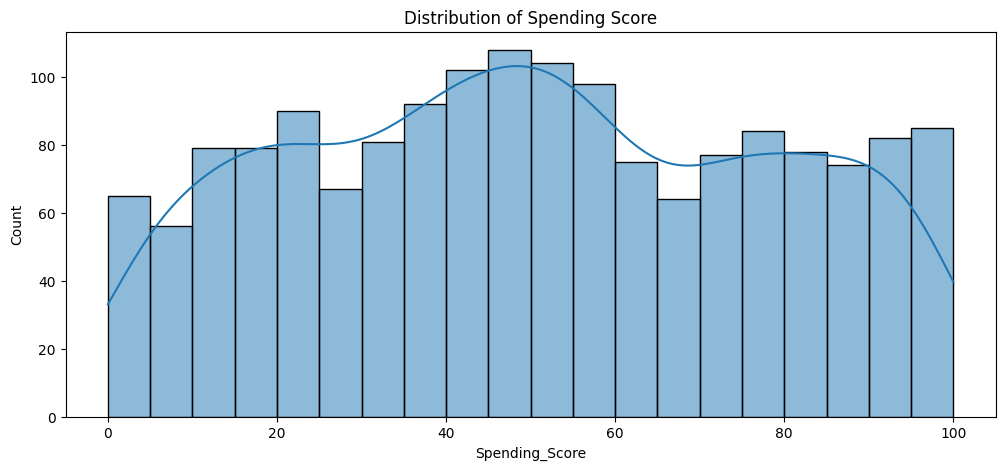

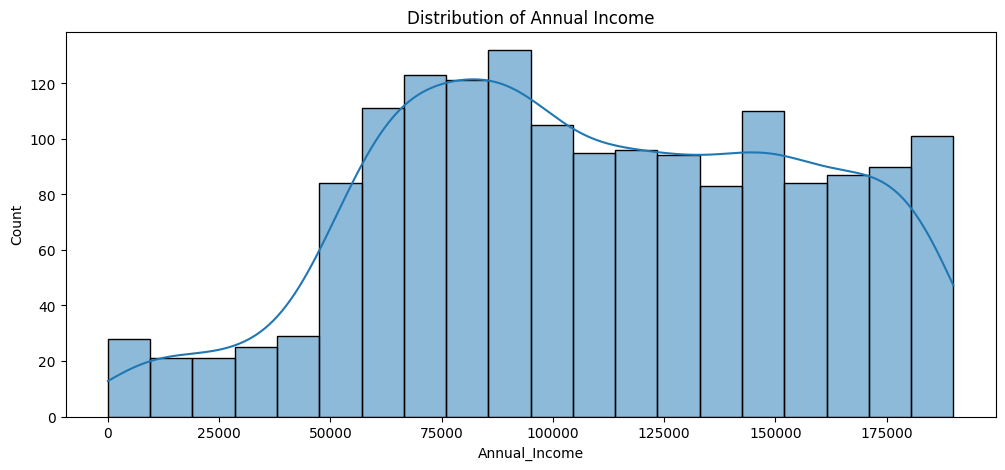


Gender Distribution in Training Set:
Gender
Female    779
Male      533
Name: count, dtype: int64

Gender Distribution in Test Set:
Gender
Female    195
Male      133
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze the distribution of categorical attributes
print("Gender Distribution:")
print(df['Gender'].value_counts())

print("\nProfession Distribution:")
print(df['Profession'].value_counts())

# Analyze the distribution of continuous attributes
plt.figure(figsize=(12, 5))
sns.histplot(df['Spending_Score'], kde=True, bins=20)
plt.title('Distribution of Spending Score')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['Annual_Income'], kde=True, bins=20)
plt.title('Distribution of Annual Income')
plt.show()

# Decide on stratification (e.g., by Gender or Profession)
# In this example, we'll stratify by Gender if needed
X = df.drop(columns=['Spending_Score'])  # Features
y = df['Spending_Score']                 # Target variable

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Gender']
)

# Verify the stratification
print("\nGender Distribution in Training Set:")
print(X_train['Gender'].value_counts())

print("\nGender Distribution in Test Set:")
print(X_test['Gender'].value_counts())

# Y-Profile , Correlation Matrix, Data Cleanup tasks

In [ ]:
!pip install ydata-profiling

In [ ]:
# Perform one-hot encoding for categorical features: Gender and Profession
encoded_df = pd.get_dummies(df, columns=['Gender', 'Profession'], dtype=int)

# Display the first few rows of the transformed DataFrame
print(encoded_df.head())

   CustomerID  Age  Family_Size  Work_Experience  Annual_Income  \
0           1   19            4                1        15000.0   
1           2   21            3                3        35000.0   
2           3   20            1                1        86000.0   
3           4   23            2                0        59000.0   
4           5   31            6                2        38000.0   

   Spending_Score  Gender_Female  Gender_Male  Profession_  Profession_Artist  \
0              39              0            1            0                  0   
1              81              0            1            0                  0   
2               6              1            0            0                  0   
3              77              1            0            0                  0   
4              40              1            0            0                  0   

   Profession_Doctor  Profession_Engineer  Profession_Entertainment  \
0                  0                   

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

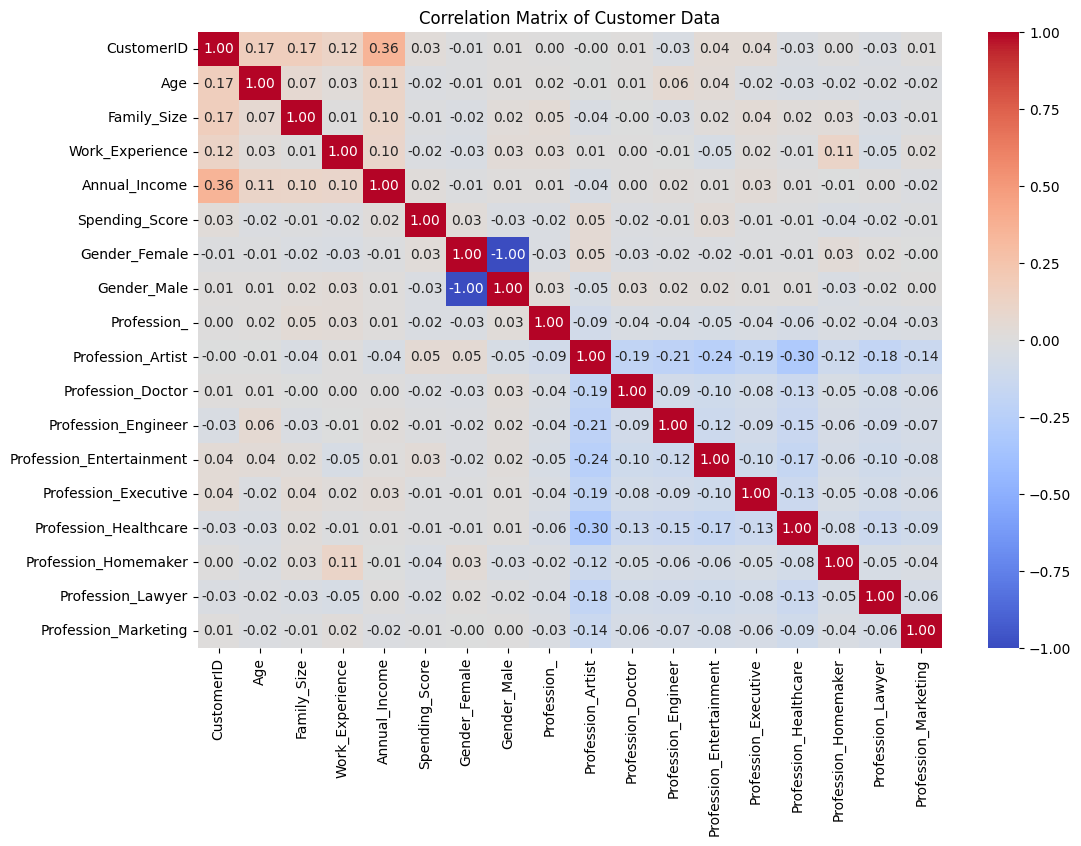


Observations:
{'missing_values': {}, 'capped_values': {'CustomerID': 34, 'Age': 17, 'Family_Size': 2, 'Work_Experience': 15, 'Annual_Income': 34, 'Spending_Score': 30}, 'strong_correlations': {}, 'weak_correlations': {('Profession_Entertainment', 'Profession_Artist'): -0.24362422953747842, ('Profession_Artist', 'Profession_Entertainment'): -0.24362422953747842, ('Profession_Engineer', 'Profession_Artist'): -0.2148851393943457, ('Profession_Artist', 'Profession_Engineer'): -0.2148851393943457, ('Profession_Doctor', 'Profession_Artist'): -0.18939282650037503, ('Profession_Artist', 'Profession_Doctor'): -0.18939282650037503, ('Profession_Executive', 'Profession_Artist'): -0.18939282650037476, ('Profession_Artist', 'Profession_Executive'): -0.18939282650037476, ('Profession_Lawyer', 'Profession_Artist'): -0.18350177575497406, ('Profession_Artist', 'Profession_Lawyer'): -0.18350177575497406, ('Profession_Entertainment', 'Profession_Healthcare'): -0.16619818626143104, ('Profession_Healthcar

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Generate a profile report using ydata-profiling
profile = ProfileReport(encoded_df, title="Customer Data Profiling Report", explorative=True)
profile.to_file("Customer_Data_Profile.html")

# Display the correlation matrix
correlation_matrix = encoded_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Customer Data")
plt.show()

# Missing values summary
missing_values = encoded_df.isnull().sum()

# Identify capped values by analyzing percentiles
capped_columns = {}
for column in encoded_df.select_dtypes(include=['float64', 'int64']).columns:
    lower_bound = encoded_df[column].quantile(0.01)
    upper_bound = encoded_df[column].quantile(0.99)
    capped_count = ((encoded_df[column] < lower_bound) | (encoded_df[column] > upper_bound)).sum()
    if capped_count > 0:
        capped_columns[column] = capped_count

# Observations and cleanup tasks
observations = {
    "missing_values": missing_values[missing_values > 0].to_dict(),
    "capped_values": capped_columns,
    "strong_correlations": correlation_matrix.unstack()
                            .sort_values(ascending=False)
                            .loc[lambda x: (x > 0.7) & (x < 1.0)].to_dict(),
    "weak_correlations": correlation_matrix.unstack()
                           .sort_values()
                           .loc[lambda x: (x < 0.3) & (x > -0.3)].to_dict(),
}

# Data cleanup tasks
data_cleanup_tasks = []

# Missing values
if observations['missing_values']:
    data_cleanup_tasks.append("Handle missing values using imputation or removal.")

# Capped values
if observations['capped_values']:
    data_cleanup_tasks.append("Investigate capped values for potential outliers.")

# Correlation insights
if observations['strong_correlations']:
    data_cleanup_tasks.append("Analyze highly correlated features for redundancy.")

# Print observations and cleanup tasks
print("\nObservations:")
print(observations)

print("\nData Cleanup Tasks:")
print(data_cleanup_tasks)

# Experiment 1

In [ ]:
%pip install -q dagshub mlflow

In [ ]:
import dagshub
dagshub.init(repo_owner='abhicjadhav', repo_name='my-first-repo', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=1a637df4-3e61-43de-b99d-bd1dcba31691&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=bf4b4c3edc84f2514843111891dfc1c5afd0c0d86f72c4b9d90703acf592344e




Accessing as abhicjadhav

Initialized MLflow to track repo "abhicjadhav/my-first-repo"

Repository abhicjadhav/my-first-repo initialized!

In [ ]:
!pip install dagshub

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
import mlflow
from mlflow import sklearn as mlflow_sklearn

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Logistic Regression Experiment ")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log_transform", FunctionTransformer(np.log1p, validate=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# Define the full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, max_iter=500))
])

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

# Cross-validation results
cv_results = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="f1")
mean_cv_score = cv_results.mean()
std_cv_score = cv_results.std()

# Predictions and evaluation on the whole training data
y_pred_train = best_model.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# Results on test data
y_pred_test = best_model.predict(X_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

if mlflow.active_run():
    mlflow.end_run()

# Log results to MLflow
with mlflow.start_run():
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("best_params", grid_search.best_params_)
    mlflow.log_metric("mean_cv_f1", mean_cv_score)
    mlflow.log_metric("std_cv_f1", std_cv_score)
    mlflow.log_metric("train_f1", f1_train)
    mlflow.log_metric("test_f1", f1_test)

    # Log confusion matrix
    mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
    mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
    mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
    mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
    mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
    mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
    mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
    mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

    # Log the model
    mlflow_sklearn.log_model(best_model, "logistic_regression_pipeline")

# Print results
print(f"Mean CV F1-Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"Training Data F1-Score: {f1_train:.4f}")
print(f"Test Data F1-Score: {f1_test:.4f}")


2024/12/19 15:32:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run calm-midge-550 at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/2/runs/6db56085f51648328e2af6c9449130f3
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/2
Mean CV F1-Score: 0.4513 ± 0.0091
Training Data F1-Score: 0.4770
Test Data F1-Score: 0.4834


# Experiment 2

In [ ]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Scikit-learn version: 1.6.0


In [ ]:
import xgboost
print("XGBoost version:", xgboost.__version__)

XGBoost version: 2.1.3


In [ ]:
!pip install -U scikit-learn xgboost

In [ ]:
import sklearn
import xgboost

print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)

Scikit-learn version: 1.6.0
XGBoost version: 2.1.3


In [ ]:
!pip install -U scikit-learn xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
import mlflow

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #2: Classifiers")


# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log_transform", FunctionTransformer(np.log1p, validate=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=500),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Experiment loop
for model_name, model in classifiers.items():

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # End any existing MLflow run
    if mlflow.active_run():
        mlflow.end_run()

    # Start a new run
    with mlflow.start_run(run_name=model_name):

        # Train and evaluate on the whole training data
        pipeline.fit(X_train, y_train)
        # y_pred_train = pipeline.predict(X_train)
        # y_pred_test = pipeline.predict(X_test)

        # Metrics
        train_f1 = f1_score(y_train, y_pred_train)
        test_f1 = f1_score(y_test, y_pred_test)

        conf_matrix_train = confusion_matrix(y_train, y_pred_train)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)

        # Log parameters, metrics, and models to MLflow
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("cv_mean_f1", mean_cv_score)
        mlflow.log_metric("cv_std_f1", std_cv_score)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
        mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
        mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
        mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
        mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
        mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
        mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
        mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

        # Log model to MLflow
        mlflow.sklearn.log_model(pipeline, model_name)

        # Print results
        print(f"Model: {model_name}")
        #print(f"Mean CV F1-Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print("=" * 40)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/19 17:45:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: XGBClassifier
Training F1-Score: 1.0000
Test F1-Score: 0.5016
🏃 View run XGBClassifier at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/5/runs/61ac7dac54004d0ea8c047cbd7e01465
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/5


# Experiment 3

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #3: Feature Engineering")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Engineering Function
def add_feature_engineering(df):
    df["Income_Per_Family"] = df["Annual_Income"] / (df["Family_Size"] + 1)  # Avoid division by zero
    df["Age_Experience_Interaction"] = df["Age"] * df["Work_Experience"]
    return df

# Apply feature engineering to training and test sets
X_train = add_feature_engineering(X_train)
X_test = add_feature_engineering(X_test)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# Define classifiers
classifiers = {
    "LogisticRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=500))
    ]),
    "RandomForestClassifier": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]),
    "RidgeClassifier": Pipeline([
         ("preprocessor", preprocessor),
         ("classifier", RidgeClassifier(random_state=42))
     ]),
    "XGBClassifier": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"))
    ])
}

# Experiment loop
for model_name, pipeline in classifiers.items():
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=f"{model_name} with Feature Engineering"):
        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # Metrics
        train_f1 = f1_score(y_train, y_pred_train)
        test_f1 = f1_score(y_test, y_pred_test)
        conf_matrix_train = confusion_matrix(y_train, y_pred_train)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("feature_engineering", "Income_Per_Family, Age_Experience_Interaction")
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
        mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
        mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
        mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
        mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
        mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
        mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
        mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

        # Log model
        mlflow.sklearn.log_model(pipeline, model_name)

        # Print results
        print(f"Model: {model_name}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print("=" * 40)

2024/12/19 18:10:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier
Training F1-Score: 0.5107
Test F1-Score: 0.5132
🏃 View run RidgeClassifier with Feature Engineering at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/7/runs/110c0d9b982946d1b6fcc03fa59973a6
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/7


# Experiment 4

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #4: Feature Selection")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Selection Functions

def correlation_threshold_selector(df, threshold=0.85):
    """Remove features with correlation above a specified threshold."""
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(columns=to_drop)

def variance_threshold_selector(df, threshold=0.01):
    """Remove features with low variance."""
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    selected_features = df.columns[selector.get_support()]
    return df[selected_features]

def feature_importance_selector(X, y, model=None, top_k=10):
    """Select top-k features based on feature importance."""
    if model is None:
        model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    top_features = feature_importances.nlargest(top_k).index
    return X[top_features]

# Perform Feature Selection
X_train_corr = correlation_threshold_selector(X_train)
X_train_var = variance_threshold_selector(X_train_corr)
X_train_feat_importance = feature_importance_selector(X_train_var, y_train)

# Preprocessing pipeline
numerical_features = X_train_feat_importance.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train_feat_importance.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# Define classifiers
classifiers = {
    "RandomForestClassifier": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]),
    "LogisticRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=500))
    ])
}

# Experiment loop
for model_name, pipeline in classifiers.items():
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=f"{model_name} with Feature Selection"):
        # Train and evaluate
        pipeline.fit(X_train_feat_importance, y_train)
        y_pred_train = pipeline.predict(X_train_feat_importance)
        y_pred_test = pipeline.predict(X_test[X_train_feat_importance.columns])

        # Metrics
        train_f1 = f1_score(y_train, y_pred_train)
        test_f1 = f1_score(y_test, y_pred_test)
        conf_matrix_train = confusion_matrix(y_train, y_pred_train)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("feature_selection_methods", "Correlation Threshold, Variance Threshold, Feature Importance")
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
        mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
        mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
        mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
        mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
        mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
        mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
        mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

        # Log model
        mlflow.sklearn.log_model(pipeline, model_name)

        # Print results
        print(f"Model: {model_name}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print("=" * 40)

2024/12/19 18:25:58 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #4: Feature Selection' does not exist. Creating a new experiment.
2024/12/19 18:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Training F1-Score: 1.0000
Test F1-Score: 0.4762
🏃 View run RandomForestClassifier with Feature Selection at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/8/runs/86facb6cd43d415cb064fb1a88e65ba6
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/8


2024/12/19 18:26:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
Training F1-Score: 0.4583
Test F1-Score: 0.4621
🏃 View run LogisticRegression with Feature Selection at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/8/runs/f0300d93ac2547f6ac3875bc76dbe5e6
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/8


#  EXPERIMENT 5

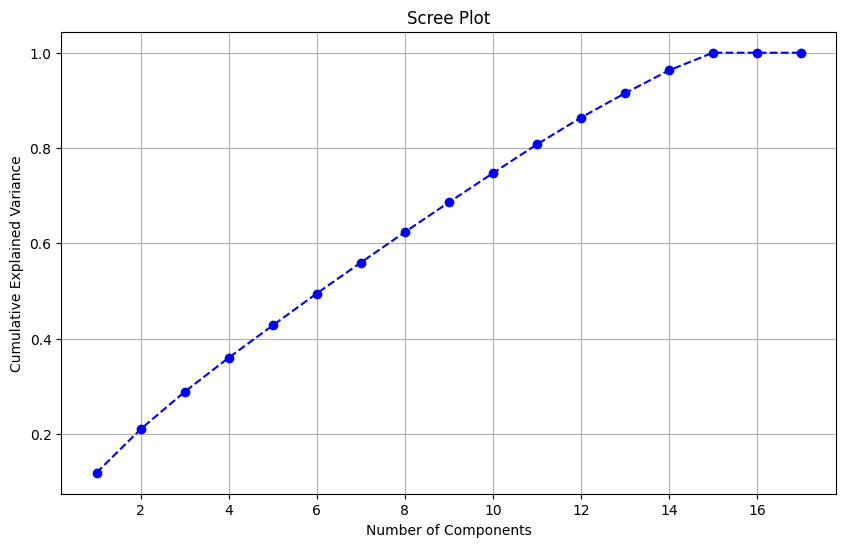

Number of components selected: 14


2024/12/19 18:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
Number of PCA Components: 14
Training F1-Score: 0.4959
Test F1-Score: 0.4733
🏃 View run LogisticRegression with PCA at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10/runs/fca5defd4ff3489682551e1b974c043f
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10


2024/12/19 18:51:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier
Number of PCA Components: 14
Training F1-Score: 0.4959
Test F1-Score: 0.4733
🏃 View run RidgeClassifier with PCA at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10/runs/89fc025556914b1eb3dc98251c44db24
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10


2024/12/19 18:51:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Number of PCA Components: 14
Training F1-Score: 1.0000
Test F1-Score: 0.5093
🏃 View run RandomForestClassifier with PCA at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10/runs/771256f5617545a69127dd525b7bf171
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:51:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/19 18:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: XGBClassifier
Number of PCA Components: 14
Training F1-Score: 1.0000
Test F1-Score: 0.5493
🏃 View run XGBClassifier with PCA at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10/runs/2f00f3e39eb7494f886df6e01cce22d0
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/10


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from io import BytesIO

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #5: PCA with Dimensionality Reduction")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# Apply preprocessing to generate transformed data for PCA
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# PCA for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_preprocessed)
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)

# Save scree plot to a BytesIO object for MLFlow logging
scree_plot_buffer = BytesIO()
plt.savefig(scree_plot_buffer, format='png')
scree_plot_buffer.seek(0)
plt.show()

# Determine number of components to retain (e.g., 95% variance)
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"Number of components selected: {n_components}")

# Update PCA with selected components
pca = PCA(n_components=n_components)
X_train_pca_reduced = pca.fit_transform(X_train_preprocessed)
X_test_pca_reduced = pca.transform(X_test_preprocessed)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=500),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}

# Experiment loop
for model_name, model in classifiers.items():
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=f"{model_name} with PCA"):
        # Log Scree Plot to MLFlow
        mlflow.log_figure(plt.gcf(), "scree_plot.png")

        # Train and evaluate
        model.fit(X_train_pca_reduced, y_train)
        y_pred_train = model.predict(X_train_pca_reduced)
        y_pred_test = model.predict(X_test_pca_reduced)

        # Metrics
        train_f1 = f1_score(y_train, y_pred_train)
        test_f1 = f1_score(y_test, y_pred_test)
        conf_matrix_train = confusion_matrix(y_train, y_pred_train)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("n_components", n_components)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
        mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
        mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
        mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
        mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
        mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
        mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
        mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

        # Log model
        mlflow.sklearn.log_model(model, model_name)

        # Print results
        print(f"Model: {model_name}")
        print(f"Number of PCA Components: {n_components}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print("=" * 40)

# EXPERIMENT - 6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #6: Custom Experiment with PCA + Feature Selection")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# Preprocess training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Feature Selection
feature_selector = VarianceThreshold(threshold=0.01)
X_train_selected = feature_selector.fit_transform(X_train_preprocessed)
X_test_selected = feature_selector.transform(X_test_preprocessed)


# Define classifiers
base_models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=500),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    #"XGBClassifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}

stacked_model = StackingClassifier(estimators=[
    ("lr", LogisticRegression(random_state=42, max_iter=500)),
    ("rf", RandomForestClassifier(random_state=42)),
    ("xgb", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"))
], final_estimator=LogisticRegression(max_iter=500, random_state=42))

# Add stacked model
base_models["StackingClassifier"] = stacked_model

# Experiment loop
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in base_models.items():
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=f"{model_name} with PCA and Feature Selection"):

        # Train on the full training data
        model.fit(X_train_pca, y_train)
        if model_name != "XGBClassifier":
            y_pred_train = model.predict(X_train_pca)
            y_pred_test = model.predict(y_train)


        # Metrics
        train_f1 = f1_score(y_train, y_pred_train)
        test_f1 = f1_score(y_test, y_pred_test)
        conf_matrix_train = confusion_matrix(y_train, y_pred_train)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("n_components", 14)
        mlflow.log_param("feature_selection", "Variance Threshold")
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
        mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
        mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
        mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
        mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
        mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
        mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
        mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

        # Log model
        mlflow.sklearn.log_model(model, model_name, input_example=X_test_pca[:5])

        # Print results
        print(f"Model: {model_name}")
        print(f"Cross-Validation F1-Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print("=" * 40)

# Experiment 7- Custom Feature Engineering and Ensemble

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn

# Configure MLflow
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")
mlflow.set_experiment("Experiment #7: RidgeClassifier in Ensemble")

# Load data
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)  # Binary classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Engineering Function
def add_custom_features(df):
    df["Income_Per_Family"] = df["Annual_Income"] / (df["Family_Size"] + 1)  # Avoid division by zero
    df["Age_Work_Interaction"] = df["Age"] * df["Work_Experience"]
    return df

X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  # Add interaction terms
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features)
])

# Preprocess training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define models
rf = RandomForestClassifier(random_state=42)
ridge = RidgeClassifier(random_state=42)
logreg = LogisticRegression(random_state=42, max_iter=500)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None]
}

rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring="f1", n_jobs=-1)

# Fit hyperparameter-tuned Random Forest
rf_grid.fit(X_train_preprocessed, y_train)

# Build ensemble (Weighted Voting)
# Build ensemble (Hard Voting)
voting_model = VotingClassifier(estimators=[
    ("rf", rf_grid.best_estimator_),
    ("ridge", ridge),
    ("logreg", logreg)
], voting="hard", weights=[2, 3, 1])

# Experiment with MLFlow
with mlflow.start_run(run_name="Custom Experiment #7 with Ridge (Hard Voting)"):
    # Train and evaluate on test set
    voting_model.fit(X_train_preprocessed, y_train)
    y_pred_train = voting_model.predict(X_train_preprocessed)
    y_pred_test = voting_model.predict(X_test_preprocessed)

    # Metrics
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)

    # Log parameters and metrics
    mlflow.log_param("feature_engineering", "Income_Per_Family, Age_Work_Interaction, Polynomial Features")
    mlflow.log_param("rf_best_params", rf_grid.best_params_)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_TP", conf_matrix_train[1, 1])
    mlflow.log_metric("train_TN", conf_matrix_train[0, 0])
    mlflow.log_metric("train_FP", conf_matrix_train[0, 1])
    mlflow.log_metric("train_FN", conf_matrix_train[1, 0])
    mlflow.log_metric("test_TP", conf_matrix_test[1, 1])
    mlflow.log_metric("test_TN", conf_matrix_test[0, 0])
    mlflow.log_metric("test_FP", conf_matrix_test[0, 1])
    mlflow.log_metric("test_FN", conf_matrix_test[1, 0])

    # Log model
    mlflow.sklearn.log_model(voting_model, "voting_model_with_ridge_hard")

    # Print results
    print("Custom Experiment #7 Results (Ridge with Hard Voting):")
    print(f"Training F1-Score: {train_f1:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("=" * 40)

2024/12/19 19:48:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Custom Experiment #7 Results (Ridge with Hard Voting):
Training F1-Score: 0.6125
Test F1-Score: 0.5105
🏃 View run Custom Experiment #7 with Ridge (Hard Voting) at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/13/runs/49ed057969ec44b5b0db9180a452e638
🧪 View experiment at: https://dagshub.com/abhicjadhav/my-first-repo.mlflow/#/experiments/13


# F1 SCORES AND CHOOSING BEST MODEL

In [ ]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

# Set up MLflow Tracking URI
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")

# Initialize MLflow Client
client = MlflowClient()

# Fetch experiments
experiments = client.search_experiments()

# Initialize dictionary to store F1 scores
experiment_metrics = {}

# Iterate over experiments to fetch runs and metrics
for exp in experiments:
    print(f"Processing Experiment: {exp.name}")
    runs = client.search_runs(exp.experiment_id)
    for run in runs:
        data = run.data
        train_f1 = data.metrics.get("train_f1")
        test_f1 = data.metrics.get("test_f1")
        if train_f1 and test_f1:
            experiment_metrics[exp.name] = {
                "train_f1": train_f1,
                "test_f1": test_f1
            }

# Print fetched metrics for verification
print("Experiment Metrics:")
for exp_name, metrics in experiment_metrics.items():
    print(f"{exp_name}: Train F1: {metrics['train_f1']}, Test F1: {metrics['test_f1']}")

Processing Experiment: Experiment #7: RidgeClassifier in Ensemble
Processing Experiment: Experiment #7: Custom Feature Engineering and Ensemble
Processing Experiment: Experiment #6: Custom Experiment with PCA + Feature Selection
Processing Experiment: Experiment #5: PCA with Dimensionality Reduction
Processing Experiment: Experiment #4: Feature Selection
Processing Experiment: Experiment #3: Feature Engineering
Processing Experiment: Experiment #2: Classifiers
Processing Experiment: Logistic Regression Experiment 
Experiment Metrics:
Experiment #7: RidgeClassifier in Ensemble: Train F1: 0.6125, Test F1: 0.5105105105105106
Experiment #6: Custom Experiment with PCA + Feature Selection: Train F1: 0.4958813838550247, Test F1: 0.47333333333333333
Experiment #5: PCA with Dimensionality Reduction: Train F1: 0.4958813838550247, Test F1: 0.47333333333333333
Experiment #4: Feature Selection: Train F1: 1.0, Test F1: 0.47619047619047616
Experiment #3: Feature Engineering: Train F1: 0.5106732348111

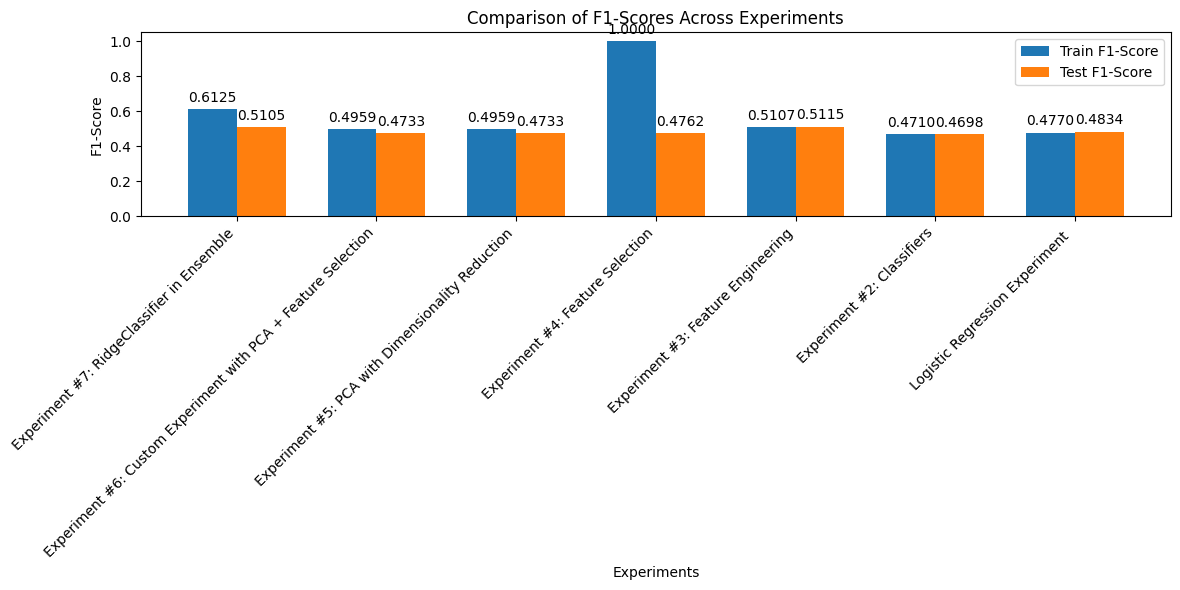

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

experiment_names = list(experiment_metrics.keys())
train_f1_scores = [metrics["train_f1"] for metrics in experiment_metrics.values()]
test_f1_scores = [metrics["test_f1"] for metrics in experiment_metrics.values()]

x = np.arange(len(experiment_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, train_f1_scores, width, label="Train F1-Score")
bars2 = ax.bar(x + width / 2, test_f1_scores, width, label="Test F1-Score")

ax.set_xlabel("Experiments")
ax.set_ylabel("F1-Score")
ax.set_title("Comparison of F1-Scores Across Experiments")
ax.set_xticks(x)
ax.set_xticklabels(experiment_names, rotation=45, ha="right")
ax.legend()

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f"{height:.4f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.4f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

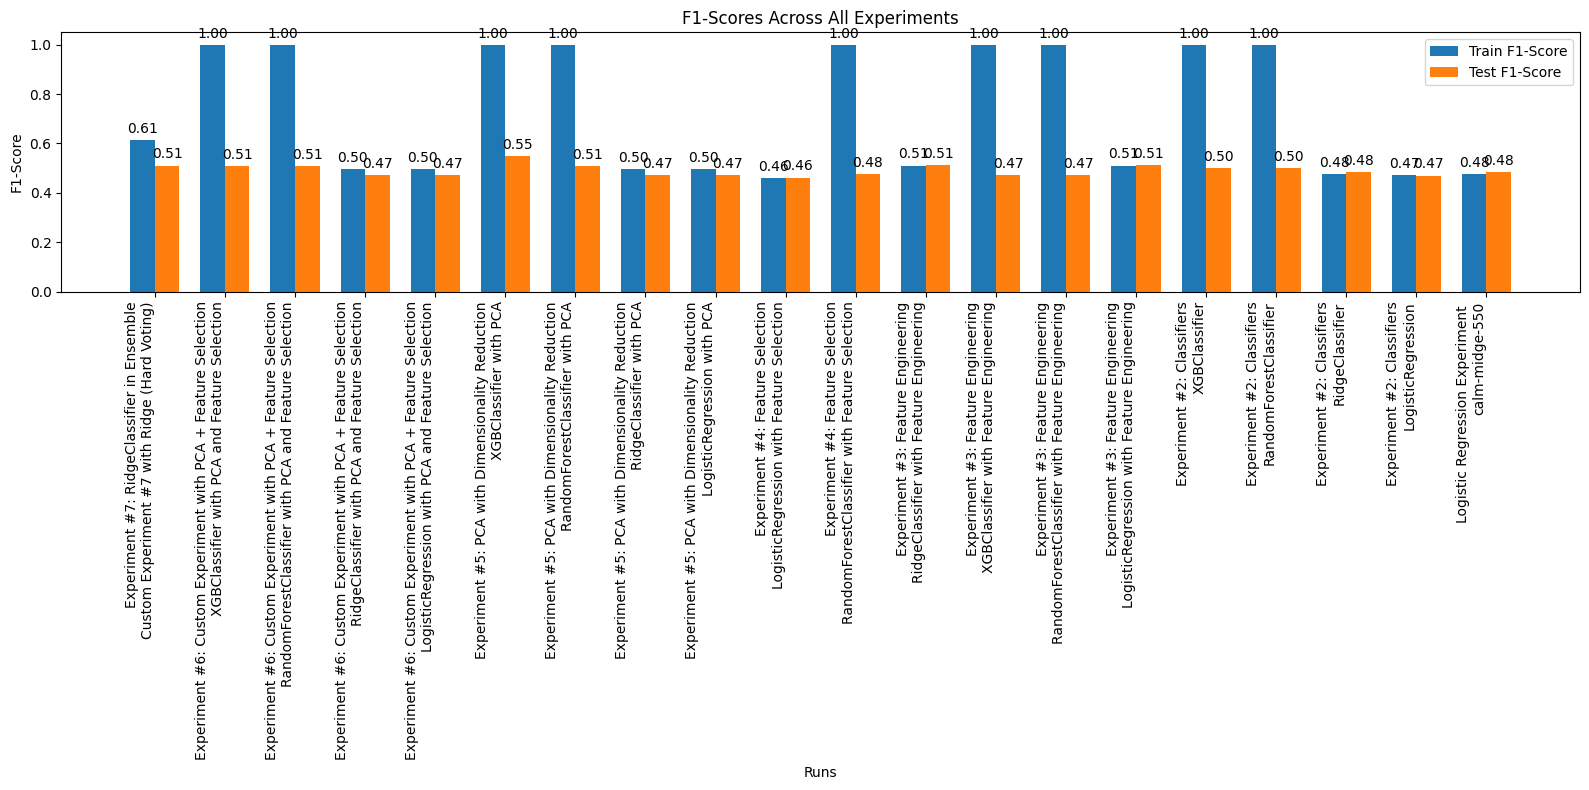

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt
import numpy as np

# Set MLflow Tracking URI
mlflow.set_tracking_uri("https://dagshub.com/abhicjadhav/my-first-repo.mlflow")

# Initialize MLflow Client
client = MlflowClient()

# Fetch all experiments
experiments = client.search_experiments()

# Initialize data storage for plotting
experiment_run_data = []

# Fetch runs and F1-scores for all experiments
for experiment in experiments:
    experiment_name = experiment.name
    runs = client.search_runs(experiment.experiment_id)

    for run in runs:
        run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
        train_f1 = run.data.metrics.get("train_f1")
        test_f1 = run.data.metrics.get("test_f1")

        if train_f1 is not None and test_f1 is not None:
            experiment_run_data.append({
                "experiment": experiment_name,
                "run_name": run_name,
                "train_f1": train_f1,
                "test_f1": test_f1
            })

# Prepare data for plotting
if experiment_run_data:
    experiments = [data["experiment"] for data in experiment_run_data]
    run_names = [data["run_name"] for data in experiment_run_data]
    train_f1_scores = [data["train_f1"] for data in experiment_run_data]
    test_f1_scores = [data["test_f1"] for data in experiment_run_data]

    # Plot F1-scores for all experiments and their runs
    x = np.arange(len(run_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 8))
    bars1 = ax.bar(x - width / 2, train_f1_scores, width, label="Train F1-Score")
    bars2 = ax.bar(x + width / 2, test_f1_scores, width, label="Test F1-Score")

    # Add labels, title, and legend
    ax.set_xlabel("Runs")
    ax.set_ylabel("F1-Score")
    ax.set_title("F1-Scores Across All Experiments")
    ax.set_xticks(x)
    ax.set_xticklabels([f"{exp}\n{run}" for exp, run in zip(experiments, run_names)], rotation=90, ha="right")
    ax.legend()

    # Annotate bars with their F1-scores
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("No F1-score data found across all experiments.")

In [ ]:
import joblib

# Assuming `ridge_model` is the RidgeClassifier from Experiment #3
joblib.dump(ridge_model, "ridge_feature_engineering_model.pkl")
print("Model saved as ridge_feature_engineering_model.pkl")

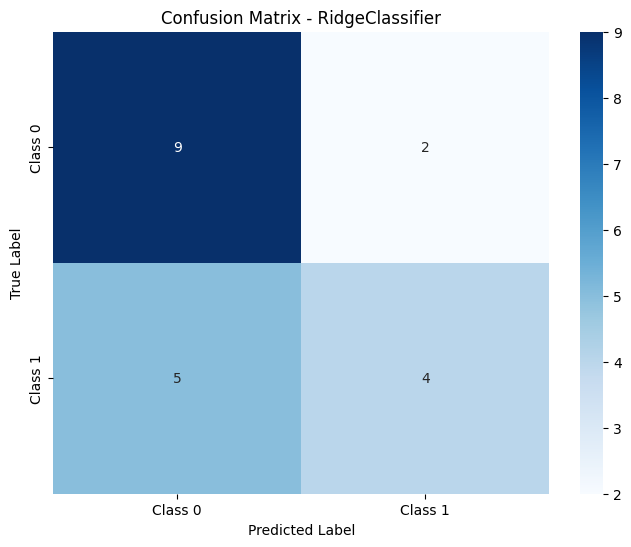

Training F1-Score: 0.4561
Test F1-Score: 0.5333
Model saved as ridge_feature_engineering_model.pkl
Confusion matrix saved as ridge_confusion_matrix.png
Feature list saved as ridge_features.txt


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Example dataset columns
columns = ["Annual_Income", "Family_Size", "Age", "Work_Experience", "Spending_Score"]

# Assuming encoded_df is your dataset
# Example placeholder: Replace with actual DataFrame loading if necessary
encoded_df = pd.DataFrame(np.random.rand(100, 5), columns=columns)
encoded_df["Spending_Score"] = (encoded_df["Spending_Score"] * 100).astype(int)

# Binary target variable
X = encoded_df.drop(columns=["Spending_Score"])
y = encoded_df["Spending_Score"].apply(lambda x: 1 if x > 50 else 0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Engineering Function
def add_feature_engineering(df):
    df["Income_Per_Family"] = df["Annual_Income"] / (df["Family_Size"] + 1)  # Avoid division by zero
    df["Age_Experience_Interaction"] = df["Age"] * df["Work_Experience"]
    return df

# Apply feature engineering
X_train = add_feature_engineering(X_train)
X_test = add_feature_engineering(X_test)

# Preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features)
])

# RidgeClassifier pipeline
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RidgeClassifier(random_state=42))
])

# Train RidgeClassifier
ridge_pipeline.fit(X_train, y_train)
y_pred_train = ridge_pipeline.predict(X_train)
y_pred_test = ridge_pipeline.predict(X_test)

# Metrics
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Feature Engineering details
feature_engineering_steps = [
    "Annual_Income",
    "Family_Size",
    "Age",
    "Work_Experience",
    "Income_Per_Family (Annual_Income / (Family_Size + 1))",
    "Age_Experience_Interaction (Age * Work_Experience)"
]

# Save the model using joblib
ridge_model_path = "ridge_feature_engineering_model.pkl"
joblib.dump(ridge_pipeline, ridge_model_path)

# Plot and save the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - RidgeClassifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
conf_matrix_path = "ridge_confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.show()

# Save feature engineering details in a text file
features_path = "ridge_features.txt"
with open(features_path, "w") as file:
    file.write("Features used in RidgeClassifier:\n")
    file.write("\n".join(feature_engineering_steps))

# Print results
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Model saved as {ridge_model_path}")
print(f"Confusion matrix saved as {conf_matrix_path}")
print(f"Feature list saved as {features_path}")

In [ ]:
import joblib
import pandas as pd

# Load the saved model
loaded_model = joblib.load("ridge_feature_engineering_model.joblib")

# Create a sample input for testing
sample_data = {
    "Annual_Income": [75000],  # Example annual income
    "Family_Size": [4],        # Example family size
    "Age": [35],               # Example age
    "Work_Experience": [10]    # Example work experience
}

# Convert the sample data into a DataFrame
sample_df = pd.DataFrame(sample_data)

# Add engineered features
sample_df["Income_Per_Family"] = sample_df["Annual_Income"] / (sample_df["Family_Size"] + 1)
sample_df["Age_Experience_Interaction"] = sample_df["Age"] * sample_df["Work_Experience"]
sample_df.head()
# Predict using the loaded model
prediction = loaded_model.predict(sample_df)

# Print the result
print(f"Prediction for the sample data: {prediction[0]}")

Prediction for the sample data: 1


In [ ]:
sample_df.dtypes

,0
Annual_Income,int64
Family_Size,int64
Age,int64
Work_Experience,int64
Income_Per_Family,float64
Age_Experience_Interaction,int64


In [ ]:
# Save the model using joblib with .joblib extension
ridge_model_path = "ridge_feature_engineering_model.joblib"
joblib.dump(ridge_pipeline, ridge_model_path)

# Function to download the saved joblib file
def download_joblib(file_path):
    import shutil
    output_path = f"{file_path}"
    shutil.copy(file_path, output_path)
    return output_path

# Save and prepare for download
download_path = download_joblib(ridge_model_path)

print(f"Model saved and available for download at: {download_path}")